In [1]:
import pandas as pd
import numpy as np
import os
import multiprocessing as mp
from matplotlib import pyplot as plt
from topicpy.hsbmpy import get_scores,normalise_score,get_scores_shuffled,add_score_lines

In [2]:
import importlib, topicpy.hsbmpy
importlib.reload(topicpy.hsbmpy)
from topicpy.hsbmpy import get_scores,normalise_score,get_scores_shuffled,add_score_lines

In [3]:
tissue = "breast"
tissue_ext = "_hv"

In [11]:
df_files = pd.read_csv(f"{tissue}/files.dat", index_col=0).dropna(how="all", axis=1).fillna("unknown")
labels = ["cancer.type" if tissue == "lung" else "Subtype_Selected"]
    
def elaborate(i, tissue, tissue_ext):
        os.system(f"mkdir -p {tissue}/multiple_{tissue+tissue_ext}/{i}/topsbm")
        os.system(f"mv -f {tissue}/multiple_{tissue+tissue_ext}/{i}/*.csv {tissue}/multiple_{tissue+tissue_ext}/{i}/topsbm/.")
        os.system(f"mv -f {tissue}/multiple_{tissue+tissue_ext}/{i}/*.tsv {tissue}/multiple_{tissue+tissue_ext}/{i}/topsbm/.")
        os.system(f"mv -f {tissue}/multiple_{tissue+tissue_ext}/{i}/*.pkl {tissue}/multiple_{tissue+tissue_ext}/{i}/topsbm/.")
        os.system(f"mv -f {tissue}/multiple_{tissue+tissue_ext}/{i}/summary.txt {tissue}/multiple_{tissue+tissue_ext}/{i}/topsbm/.")
        os.system(f"mv -f {tissue}/multiple_{tissue+tissue_ext}/{i}/*.png {tissue}/multiple_{tissue+tissue_ext}/{i}/topsbm/.")
        return get_scores(f"{tissue}/multiple_{tissue+tissue_ext}/{i}", labels, df_files, algorithm='topsbm', verbose=False)[labels[0]]
    
def estimate_scores(tissue, tissue_ext="", normalised =True):
    pool = mp.Pool(4)
    temp = [pool.apply_async(elaborate,([i, tissue, tissue_ext])) for i in range(10)]
    pool.close()
    pool.join()
    scores = {}
    for i in range(10):
        scores[f'hsbm-seed{i}'] = temp[i].get()
    
    scores['shuffle'] = get_scores_shuffled(f"{tissue}/", df_files, label=labels[0], algorithm='topsbm')
    temp = []
    pool = mp.Pool(2)
    for _ in range(5):
        temp.append(pool.apply_async(get_scores_shuffled,([f"{tissue}/", df_files, 'topsbm', labels[0], False])))
    pool.close()
    pool.join()  
    scores["shuffle"]["V"]=np.average([j.get()["V"] for j in temp], axis=0)
    if normalised:
        if "mixed" in scores.keys():
            scores.pop("mixed")
        normalise_score(scores, base_algorithm="shuffle", operation=lambda x,y: x/y)
    return scores

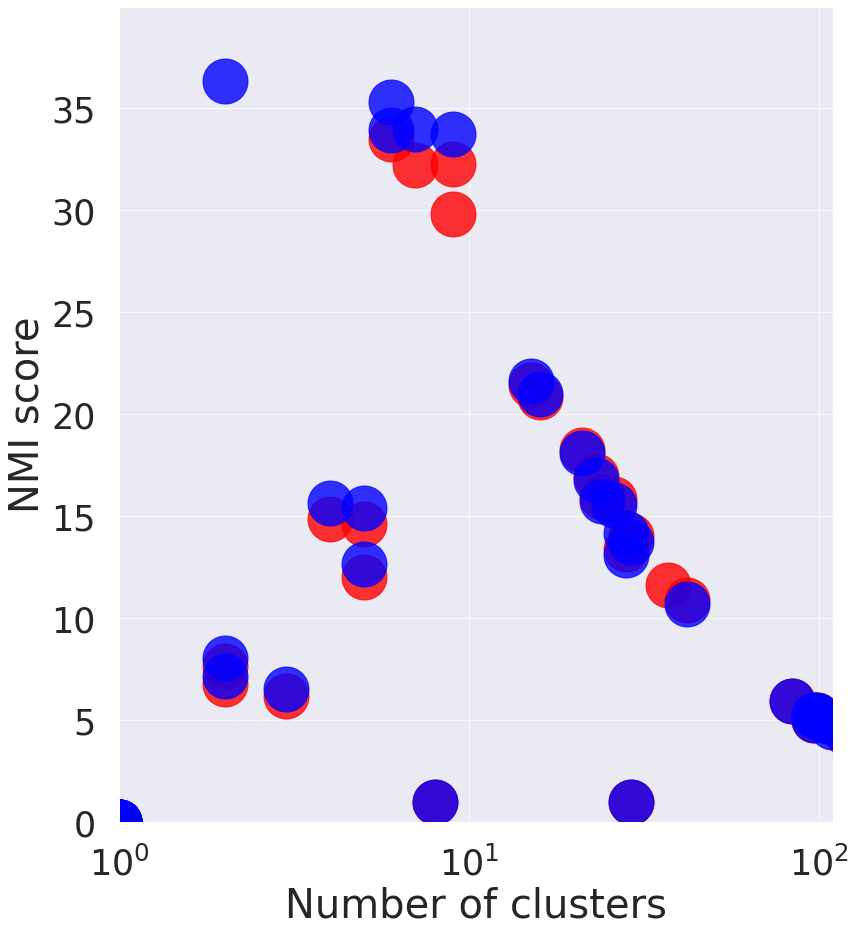

In [13]:
fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)

norm = "norm_V"

scores = estimate_scores(tissue, tissue_ext, True)
add_score_lines(ax,scores, V=norm, labels=["shuffle"]+[f'hsbm-seed{i}' for i in range(10)])
m = max([max(s[norm]) for s in scores.values()])

scores = estimate_scores(tissue, "", True)
add_score_lines(ax,scores, V=norm, labels=["shuffle"]+[f'hsbm-seed{i}' for i in range(10)])

#ax.set_xscale('linear')
n_lines = int(len(ax.get_lines())/2)
list(map(lambda l: l.set_lw(0), ax.get_lines()))
list(map(lambda l: l.set_alpha(0.8), ax.get_lines()))
list(map(lambda l: l.set_c("blue" if tissue == "lung" else "red"), ax.get_lines()[:n_lines]))
list(map(lambda l: l.set_c("red" if tissue == "lung" else "blue"), ax.get_lines()[n_lines:]))

ax.get_legend().remove()
plt.xlim(1,110)
plt.ylim(0,max([m,max([max(s[norm]) for s in scores.values()])])*1.1)
plt.show()
fig.savefig(f"{tissue}/multiple_{tissue+tissue_ext}/metric_scores_{norm}.pdf")

In [6]:
n_lines

11

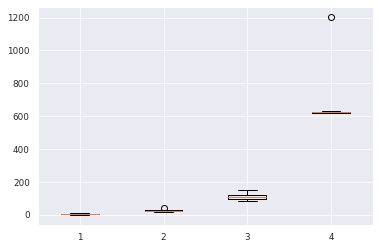

In [7]:
plt.boxplot(list(zip(*[s["xl"] for s in scores.values()]))[::-1])
#plt.yscale("log")
plt.show()

In [8]:
l=ax.get_lines()[0]
l.set_c("red")

In [9]:
l=ax.get_lines()[0]

In [10]:
l.set_alpha(10)